In [2]:
using Revise
includet("paper.jl")

using Gnuplot
import Base.show
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")

using DataFrames, DataFramesMeta, CSV
using JLD2
using DelimitedFiles

## Model Descriptions
The output of `modelresults` includes the Bayesian inference of all the parameters of the model specifically the posterior distributions of :ρ, β, and θ. The output also includes the posterior predictive checks.

### Limitation

When inferring the parameters of rho, beta, and theta, the model uses all data (both unvaccinated and vaccinated matrices). This means that rho and beta are "contaminated" and include the effect of vaccine in the inference. However, we tested this effect two ways: We trained rho and beta using only the first 4 data points (i.e., set `max_t = 4` in the `model` function). This slightly changed the values of rho and beta (but did not change the overall parameter λ since it's the combination of rho and beta). This is "flawed" in the sense that if we were to fix these numbers (i.e. keep them constants) for post-vaccination, then why do we need to train theta, only to turn it off and return back to the constant values. 

In a second test, we set `max_d = 1`. This means we are inferring the values of rho and beta using the unvaccinated data only. This result produced almost exact results as if we included the vaccinated data. This implies the effect of direct vaccine is mostly captured by theta. It is true that rho/beta are also being adjusted but this adjustment is very very minor as shown by the test (and in fact, we can not differentiate whether the effect is due to vaccine data or just stochasticity)

One important note is the effect of indirect dynamics. We see in the "non vaccinated" data that there is a declining trend. This declining trend is likely due to vaccine (i.e. herd immunity) so it's impossible to figure out exactly what the direct effect is. 

In [75]:
savefile = "./output/model_output_ag45.csv" # if replicating, make sure output folder exists
savefile_tp = "./output/posterior_distributions_ag45.csv"
maxiter=5000
modelresults, data, popsize = run_model(;iter=maxiter, ag45=true)
max_ag, max_t, max_d = size(data) # maximum age group, time, vaccine 
println("dimensions: max_ag: $max_ag, max_t: $max_t, max_d: $max_d")
modelresults

running model - params: iter: 5000, ag45: true


┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/affans/.julia/packages/Turing/lkUBK/src/mcmc/hmc.jl:191


dimensions: max_ag: 7, max_t: 21, max_d: 2


Chains MCMC chain (5000×41×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 12.85 seconds
Compute duration  = 12.85 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9], b[10], b[11], b[12], b[13], b[14], b[15], b[16], b[17], b[18], b[19], b[20], b[21], θ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse   ess_bulk    ess_tail      rhat   ⋯
      Symbol    Float64   Float64   Float64    Float64     Float64   Float64   ⋯

        ρ[1]   -11.2482    0.0983    0.0037   723.6896   1267.8501    1.0000   ⋯
        ρ[2]   -12.5876    0.0978    0.0037   716.6509   1346.3585    1.0000   ⋯
        ρ[3]   -13.5169    0.1028    0.0037   769.86

In [76]:
# we need to turn thetha off to turn off the vaccine effects
# have to get to the internals of the model to turn off thetha 
rho, rhoquants = describe(group(modelresults, :ρ)) .|> DataFrame
beta, betaquants = describe(group(modelresults, :b)) .|> DataFrame
theta, thetaquants = describe(group(modelresults, :θ)) .|> DataFrame

# means and quantiles
rmeans = rho.mean
bmeans = beta.mean
tmeans = theta.mean
rupper = rhoquants[!, Symbol("97.5%")]
rlower = rhoquants[!, Symbol("2.5%")]
bupper = betaquants[!, Symbol("97.5%")]
blower = betaquants[!, Symbol("2.5%")]
tupper = thetaquants[!, Symbol("97.5%")]
tlower = thetaquants[!, Symbol("2.5%")]

# write the code to get the results 
poster = similar(data, Float64)
poster_upper = similar(data, Float64)
poster_lower = similar(data, Float64)

poster_thetaon = similar(data, Float64)
poster_upper_thetaon = similar(data, Float64)
poster_lower_thetaon = similar(data, Float64)
for d = 1:max_d
    for t = 1:max_t
        for ag = 1:max_ag
            if d == 1 # no vaccine 
                λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] #bmeans[t]
                λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t]
                λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]
                poster[ag, t, d] = mean(Poisson(exp(λ)))
                poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))

                # since theta = 0 by definition
                poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))
                
            else 
                if popsize[ag, t, d] > 0 
                    λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] #+ tmeans[1]
                    λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t]# + tupper[1]
                    λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]# + tlower[1]
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))

                    λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] + tmeans[1]
                    λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t] + tupper[1]
                    λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t] + tlower[1]
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))
                else 
                    poster[ag, t, d] = mean(Poisson(0))
                    poster_upper[ag, t, d] = mean(Poisson(0))
                    poster_lower[ag, t, d] = mean(Poisson(0))

                    poster_thetaon[ag, t, d] = mean(Poisson(0))
                    poster_upper_thetaon[ag, t, d] = mean(Poisson(0))
                    poster_lower_thetaon[ag, t, d] = mean(Poisson(0))
                end 
                # λ = log(K[ag, t, d] + 1) + ρ[ag] + b[t] + θ
                # data[ag, t, d] ~ Poisson(exp(λ)) 
            end
            #poster[ag, t, d] = mean(Poisson(exp(λ)))
        end
    end
end
total_mean_manual = dropdims(sum(poster, dims=3);dims=3)
total_mean_upper = dropdims(sum(poster_upper, dims=3);dims=3)
total_mean_lower = dropdims(sum(poster_lower, dims=3);dims=3)

total_mean_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)
total_mean_upper_thetaon = dropdims(sum(poster_upper_thetaon, dims=3);dims=3)
total_mean_lower_thetaon = dropdims(sum(poster_lower_thetaon, dims=3);dims=3)

# check the difference between manual calculation and automatic predict function (should be the same or close enough)
# total_mean_manual - total_mean
function generate_df_from_poster(p) 
    # _novax = reshape(p[:, :, 1], (120)) # I think this shapes it correctly 
    # _wivax = reshape(p[:, :, 2], (120))
    # vcat(_novax, _wivax)
    reshape(p, (max_t * max_ag))
end
# create a dataframe to plot the results / send to colleagues
_thethaoff_df = DataFrame(idx = 1:(max_t * max_ag),
                        mean_thetaon = generate_df_from_poster(total_mean_thetaon),
                        lower_thetaon = generate_df_from_poster(total_mean_lower_thetaon),
                        upper_thetaon = generate_df_from_poster(total_mean_upper_thetaon),
                        mean_thetaoff = generate_df_from_poster(total_mean_manual),
                        lower_thetaoff = generate_df_from_poster(total_mean_lower), 
                        upper_thetaoff = generate_df_from_poster(total_mean_upper))

CSV.write("$savefile", _thethaoff_df)
_thethaoff_df

Row,idx,mean_thetaon,lower_thetaon,upper_thetaon,mean_thetaoff,lower_thetaoff,upper_thetaoff
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,78.7244,54.0569,114.069,78.7244,54.0569,114.069
2,2,78.5708,53.9188,114.396,78.5708,53.9188,114.396
3,3,49.6249,33.7515,73.2325,49.6249,33.7515,73.2325
4,4,308.791,214.169,445.107,308.791,214.169,445.107
5,5,289.312,201.2,416.069,289.312,201.2,416.069
6,6,146.284,101.321,210.958,146.284,101.321,210.958
7,7,240.275,166.797,346.706,240.275,166.797,346.706
8,8,54.0925,37.1688,78.6625,54.0925,37.1688,78.6625
9,9,55.5123,38.1213,81.117,55.5123,38.1213,81.117


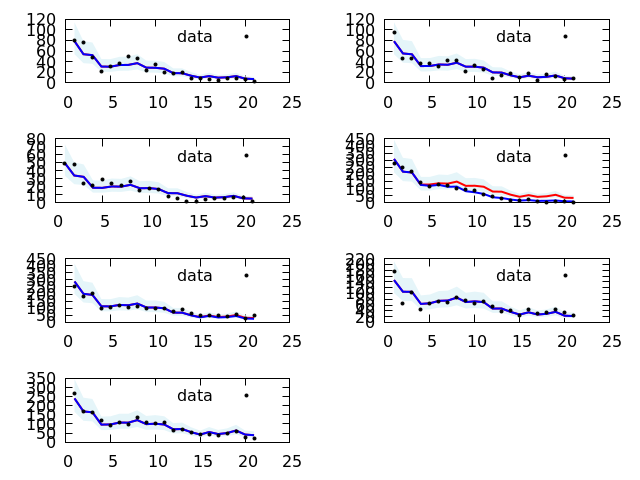

mean difference ag4: 541.0, range: 377.0 - 771.0
mean difference ag5: 30.0, range: 20.0 - 43.0
deaths prevented: 49.0 range: 34.0 - 70.0
deaths prevented: 3.0 range: 2.0 - 5.0


In [77]:
# plot the results + print out the statistics
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
@gp "reset" 
@gp :- "set multiplot layout 4,2 "

# plot the bayesian model results 
for i = 1:max_ag
    @gp :- i 1:max_t total_mean_lower[i, :] total_mean_upper[i, :] "with filledcu notitle lc rgb '#e5f5f9'"
end

for i = 1:max_ag
    @gp :- i 1:max_t total_mean_manual[i, :] "with lines notitle lw 2 lc 'red'" :-
end

for i = 1:max_ag
    @gp :- i 1:max_t total_mean_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
end
# plot the data
for i = 1:max_ag
    @gp :- i 1:max_t (data[i, :, 1] + data[i, :, 2]) "with points title 'data' pointtype 7 pointsize 0.5 lc 'black'" :-
end
display(@gp)

mean_diff_ag4 = round(sum(abs.(total_mean_manual[4, :] - total_mean_thetaon[4, :])))
mean_diff_ag5 = round(sum(abs.(total_mean_manual[5, :] - total_mean_thetaon[5, :])))
lower_diff_ag4 = round(sum(abs.(total_mean_lower[4, :] - total_mean_lower_thetaon[4, :])))
lower_diff_ag5 = round(sum(abs.(total_mean_lower[5, :] - total_mean_lower_thetaon[5, :])))
upper_diff_ag4 = round(sum(abs.(total_mean_upper[4, :] - total_mean_upper_thetaon[4, :])))
upper_diff_ag5 = round(sum(abs.(total_mean_upper[5, :] - total_mean_upper_thetaon[5, :])))

# if ag45 = true, then ag4 and ag5 are combined so just look at the first println
println("mean difference ag4: $mean_diff_ag4, range: $lower_diff_ag4 - $upper_diff_ag4")
println("mean difference ag5: $mean_diff_ag5, range: $lower_diff_ag5 - $upper_diff_ag5")

cfr_rate_ag4 = 0.091 
cfr_rate_ag5 = 0.116 
println("deaths prevented: $(round(mean_diff_ag4 * cfr_rate_ag4)) range: $(round(lower_diff_ag4 * cfr_rate_ag4)) - $(round(upper_diff_ag4 * cfr_rate_ag4))")
println("deaths prevented: $(round(mean_diff_ag5 * cfr_rate_ag5)) range: $(round(lower_diff_ag5 * cfr_rate_ag5)) - $(round(upper_diff_ag5 * cfr_rate_ag5))")

plotting traceplot only for rho: itertions: 5000


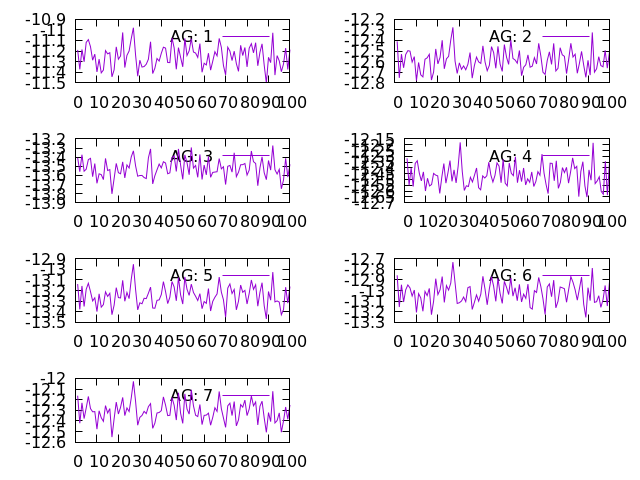

In [78]:
# plot/save the trace plots 
val = get(modelresults, [:ρ, :b, :θ])

println("plotting traceplot only for rho: itertions: $(maxiter)")
# don't plot all 40,000 
@gp "reset" 
@gp :- "set multiplot layout 4,2 "
for g = 1:max_ag
    @gp :- g 1:length(val.ρ[g].data[1:50:maxiter]) val.ρ[g].data[1:50:maxiter] "with lines title 'AG: $(g)" :- 
end 
display(@gp)

# create a dataframe to save the results 

mf_df = DataFrame(modelresults)
nonused_colnames = Symbol.(["iteration", "chain", "lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"])
select!(mf_df, Not(nonused_colnames));
CSV.write("$savefile_tp", mf_df)

# print out the credible intervals as vscodedisplay to make copy/paste easier
strvals = Vector{String}(undef, length(val.ρ))
for (i, p) in enumerate(val.ρ)
    mval = round(mean(p.data), digits = 3)
    qval = round.(quantile(p.data, [0.025, 0.975]), digits=3)
    strvals[i] = "$mval ($(qval[1]), $(qval[2]))"
end
#vscodedisplay(DataFrame(s = strvals))

strvals = Vector{String}(undef, length(val.b))
for (i, p) in enumerate(val.b)
    mval = round(mean(p.data), digits = 3)
    qval = round.(quantile(p.data, [0.025, 0.975]), digits=3)
    strvals[i] = "$mval ($(qval[1]), $(qval[2]))"
end
#vscodedisplay(DataFrame(s = strvals))

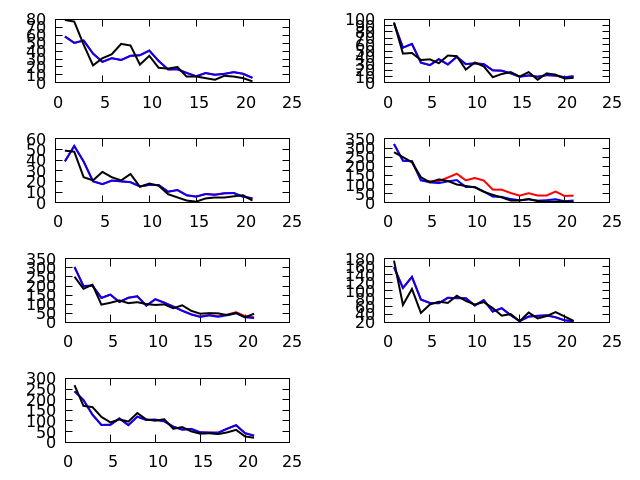

BoundsError: BoundsError: attempt to access 147×1000 Matrix{Float64} at index [[4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100, 108, 116, 124, 132, 140, 148, 156, 164], 1:1000]

In [79]:
# similar to above but sample from the distributions 
# write the code to get the results 
function sample_curves() 
    val = get(modelresults, [:ρ, :b, :θ])   
    # this function returns one single realization 
    poster = similar(data, Float64)
    poster_thetaon = similar(data, Float64)
    for d = 1:max_d
        for t = 1:max_t
            for ag = 1:max_ag
                # sample the numbers 
                rsamp = rand(val.ρ[ag].data)
                bsamp = rand(val.b[t].data)
                tsamp = rand(val.θ.data)
                if d == 1 # no vaccine 
                    λ = log(popsize[ag, t, d]) + rsamp + bsamp
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ))) # since theta = 0 by definition

                else 
                    if popsize[ag, t, d] > 0 
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp #+ tmeans[1]
                        poster[ag, t, d] = mean(Poisson(exp(λ)))
                        
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp + tsamp
                        poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    else 
                        poster[ag, t, d] = mean(Poisson(0))
                        poster_thetaon[ag, t, d] = mean(Poisson(0))
                    end 
                end
            end
        end
    end
    # sum the infections (due to no vaccine subgroup and vaccine subgroup together) 
    total_inf_thetaoff = dropdims(sum(poster, dims=3);dims=3)
    total_inf_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)

    return total_inf_thetaoff, total_inf_thetaon
end
total_inf_thetaoff, total_inf_thetaon = sample_curves()
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
@gp "reset" 
@gp :- "set multiplot layout 4,2 "
for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaoff[i, :] "with lines notitle lw 2 lc 'red'" :-
end

for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
end
# plot the data
for i = 1:max_ag
    @gp :- i 1:max_t (data[i, :, 1] + data[i, :, 2]) "with lines notitle lw 2 lc 'black'" :-
end
display(@gp)


# use the above function to sample 1000 curves 
nsims = 1000
curves_thetaon = zeros(Float64, max_ag*max_t, nsims)
curves_thetaoff = zeros(Float64, max_ag*max_t, nsims)
for i = 1:nsims 
    _total_inf_thetaoff, _total_inf_thetaon = sample_curves()
    total_inf_thetaoff = vec(_total_inf_thetaoff)
    total_inf_thetaon = vec(_total_inf_thetaon)
    curves_thetaoff[:, i] .= total_inf_thetaoff
    curves_thetaon[:, i] .= total_inf_thetaon
end
#writedlm("./output/sampled_curves_thetaoff.csv", curves_thetaoff, ',')
#writedlm("./output/sampled_curves_thetaon.csv", curves_thetaon, ',')

# fix code if using consolidated age groups 4 and 5
diff = abs.(curves_thetaon .- curves_thetaoff)
ag4_idx = collect(4:8:168)
ag4_diff = diff[ag4_idx, :]
ag4_cumdiff = vec(sum(ag4_diff, dims=1))
ag4_mean = mean(ag4_cumdiff)
ag4_quants = quantile(ag4_cumdiff, [0.025, 0.975])
println("mean: $(ag4_mean), quantiles: $(ag4_quants)")